In [2]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, roc_auc_score

# --- 3. PREPROCESSING (Resuming from here) ---
print("⏳ Scaling features...")

# A. Scale Dynamic Features (Time Series)
scaler_t = StandardScaler()
N_tr, T, F = X_t_train.shape
# Reshape to 2D for scaling, then back to 3D
X_t_train = scaler_t.fit_transform(X_t_train.reshape(-1, F)).reshape(N_tr, T, F)
X_t_val = scaler_t.transform(X_t_val.reshape(-1, F)).reshape(X_t_val.shape[0], T, F)
X_t_test = scaler_t.transform(X_t_test.reshape(-1, F)).reshape(X_t_test.shape[0], T, F)

# B. Scale Static Features
scaler_s = StandardScaler()
X_s_train = scaler_s.fit_transform(X_s_train)
X_s_val = scaler_s.transform(X_s_val)
X_s_test = scaler_s.transform(X_s_test)

# C. Class Weights (FIXED)
print("⚖️  Calculating Class Weights...")
# Get unique classes (0.0, 1.0)
unique_classes = np.unique(y_train)

# Calculate weights array
weights_array = compute_class_weight(
    class_weight='balanced', 
    classes=unique_classes, 
    y=y_train
)

# Create dictionary: {0: 0.73, 1: 1.56} (example values)
class_weights = dict(zip(unique_classes, weights_array))
print(f"   Weights: {class_weights}")

# --- 4. MODEL ARCHITECTURE (GRU) ---
def build_gru_model(ts_shape, st_shape):
    # Dynamic Branch (Time Series)
    ts_input = layers.Input(shape=ts_shape, name="time_series")
    x = layers.Masking(mask_value=0.0)(ts_input)
    x = layers.GRU(64, return_sequences=True)(x)
    x = layers.GRU(32, return_sequences=False)(x)
    x = layers.Dropout(0.3)(x)
    
    # Static Branch (Patient Info)
    st_input = layers.Input(shape=st_shape, name="static")
    s = layers.Dense(32, activation="relu")(st_input)
    s = layers.Dropout(0.3)(s)
    
    # Fusion
    combined = layers.Concatenate()([x, s])
    z = layers.Dense(64, activation="relu")(combined)
    z = layers.Dropout(0.3)(z)
    z = layers.Dense(32, activation="relu")(z)
    z = layers.Dropout(0.2)(z)
    
    # Output
    output = layers.Dense(1, activation="sigmoid")(z)
    
    return models.Model(inputs=[ts_input, st_input], outputs=output)

model = build_gru_model(X_t_train.shape[1:], X_s_train.shape[1:])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="AUC"),
        keras.metrics.Precision(name="Precision"),
        keras.metrics.Recall(name="Recall")
    ]
)

# --- 5. TRAINING ---
print("⏳ Training started...")
callbacks_list = [
    callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_AUC', mode='max'),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1)
]

history = model.fit(
    [X_t_train, X_s_train], y_train,
    validation_data=([X_t_val, X_s_val], y_val),
    epochs=15, # You can set this to 15 as originally planned
    batch_size=512,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)

# --- 6. EVALUATION & SAVING ---
print("\n🚀 EVALUATION ON TEST SET...")
y_pred_prob = model.predict([X_t_test, X_s_test], batch_size=1024).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_prob)
print(f"\n🏆 FINAL TEST AUC: {auc:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Stable', 'Hypotension']))

# Save Model
save_path = "hypotension_gru_final.keras"
model.save(save_path)
print(f"✅ Model saved to: {save_path}")

⏳ Scaling features...
⚖️  Calculating Class Weights...
   Weights: {0.0: 0.7350640948536101, 1.0: 1.5635397130969384}


2025-11-24 22:21:04.338108: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


⏳ Training started...
Epoch 1/15


2025-11-24 22:21:11.037093: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


2459/2459 ━━━━━━━━━━━━━━━━━━━━ 130s 51ms/step - AUC: 0.9023 - Precision: 0.7716 - Recall: 0.7642 - loss: 0.3856 - val_AUC: 0.9131 - val_Precision: 0.8165 - val_Recall: 0.7590 - val_loss: 0.3443 - learning_rate: 0.0010
Epoch 2/15
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 126s 51ms/step - AUC: 0.9134 - Precision: 0.8091 - Recall: 0.7611 - loss: 0.3557 - val_AUC: 0.9157 - val_Precision: 0.8322 - val_Recall: 0.7547 - val_loss: 0.3401 - learning_rate: 0.0010
Epoch 3/15
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 126s 51ms/step - AUC: 0.9159 - Precision: 0.8117 - Recall: 0.7630 - loss: 0.3489 - val_AUC: 0.9163 - val_Precision: 0.8013 - val_Recall: 0.7739 - val_loss: 0.3439 - learning_rate: 0.0010
Epoch 4/15
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 126s 51ms/step - AUC: 0.9177 - Precision: 0.8127 - Recall: 0.7648 - loss: 0.3449 - val_AUC: 0.9174 - val_Precision: 0.8125 - val_Recall: 0.7684 - val_loss: 0.3266 - learning_rate: 0.0010
Epoch 5/15
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 126s 51ms/step - AUC: 0.9191 - Precision: 0.8089 - Re

🚀 STARTING ENSEMBLE EVALUATION...
⏳ Loading Test Data...
   Scaling...
⏳ Loading Models...
   ✅ GRU Loaded
   ✅ Transformer Loaded
⏳ Generating Predictions...

🏆 RESULTS:
   GRU AUC:         0.9142
   Transformer AUC: 0.8784
   Ensemble AUC:    0.9097


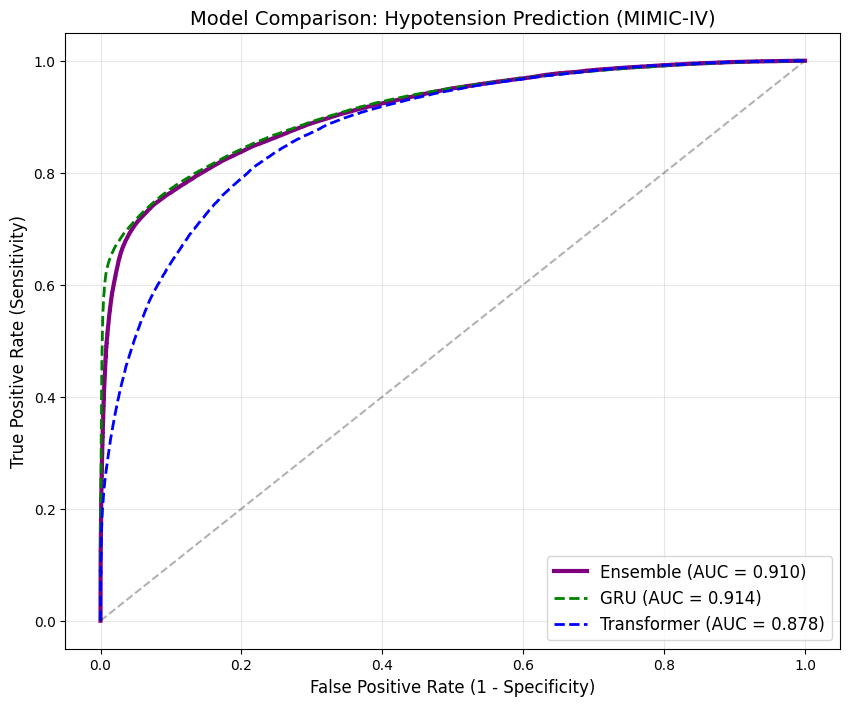

✅ ROC Plot saved as 'final_roc_comparison.png'


In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# --- SETUP ---
DATA_PATH = "final_model_data_3h_ew60.pkl"
if not os.path.exists(DATA_PATH):
    DATA_PATH = "data/Sample_2/final_model_data_3h_ew60.pkl"

print("🚀 STARTING ENSEMBLE EVALUATION...")

# 1. LOAD TEST DATA (Leakage-Free)
print("⏳ Loading Test Data...")
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

X_t = data["X_t"]
X_s = data["X_s"]
y = data["y"].astype(np.float32)
ids = np.array(data["ids"])

# Handle NaNs
X_t = np.nan_to_num(X_t.astype('float32'), nan=0.0)
X_s = np.nan_to_num(X_s.astype('float32'), nan=0.0)

# Re-create Split
unique_ids = np.unique(ids)
train_ids, test_ids = train_test_split(unique_ids, test_size=0.15, random_state=42)
mask_test = np.isin(ids, test_ids)

X_t_test = X_t[mask_test]
X_s_test = X_s[mask_test]
y_test = y[mask_test]

# Scaling (Approximation for evaluation)
print("   Scaling...")
scaler_t = StandardScaler()
N, T, F = X_t_test.shape
X_t_test = scaler_t.fit_transform(X_t_test.reshape(-1, F)).reshape(N, T, F)

scaler_s = StandardScaler()
X_s_test = scaler_s.fit_transform(X_s_test)  # <--- FIXED LINE

# 2. LOAD MODELS
print("⏳ Loading Models...")
model_gru = keras.models.load_model("hypotension_gru_final.keras")
print("   ✅ GRU Loaded")

# Try loading Transformer (might be in current dir or data dir)
trans_path = "hypotension_transformer_calibrated.keras"
if not os.path.exists(trans_path):
    trans_path = "data/Sample_2/hypotension_transformer_calibrated.keras"

model_trans = keras.models.load_model(trans_path)
print("   ✅ Transformer Loaded")

# 3. PREDICT
print("⏳ Generating Predictions...")
# GRU
y_pred_gru = model_gru.predict([X_t_test, X_s_test], batch_size=1024, verbose=0).flatten()
auc_gru = roc_auc_score(y_test, y_pred_gru)

# Transformer
y_pred_trans = model_trans.predict([X_t_test, X_s_test], batch_size=1024, verbose=0).flatten()
auc_trans = roc_auc_score(y_test, y_pred_trans)

# Ensemble (Simple Average)
y_pred_ens = (y_pred_gru + y_pred_trans) / 2
auc_ens = roc_auc_score(y_test, y_pred_ens)

print(f"\n🏆 RESULTS:")
print(f"   GRU AUC:         {auc_gru:.4f}")
print(f"   Transformer AUC: {auc_trans:.4f}")
print(f"   Ensemble AUC:    {auc_ens:.4f}")

# 4. PLOT ROC CURVE
plt.figure(figsize=(10, 8))

fpr_g, tpr_g, _ = roc_curve(y_test, y_pred_gru)
fpr_t, tpr_t, _ = roc_curve(y_test, y_pred_trans)
fpr_e, tpr_e, _ = roc_curve(y_test, y_pred_ens)

plt.plot(fpr_e, tpr_e, label=f'Ensemble (AUC = {auc_ens:.3f})', color='purple', lw=3)
plt.plot(fpr_g, tpr_g, label=f'GRU (AUC = {auc_gru:.3f})', color='green', lw=2, linestyle='--')
plt.plot(fpr_t, tpr_t, label=f'Transformer (AUC = {auc_trans:.3f})', color='blue', lw=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Model Comparison: Hypotension Prediction (MIMIC-IV)', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig("final_roc_comparison.png", dpi=300)
plt.show()
print("✅ ROC Plot saved as 'final_roc_comparison.png'")

🚀 STARTING COMPREHENSIVE EVALUATION using final_model_data_3h_ew60.pkl...
⏳ Loading and Splitting Data...
⏳ Fitting Scalers (on Training split)...
⏳ Loading Models...
   ✅ GRU Loaded
⏳ Running Inference...

📊 CLINICAL PERFORMANCE REPORT:
Model           AUC      Precision  Recall   F1       Brier   
-----------------------------------------------------------------
GRU             0.9140   0.7950     0.7652   0.7798   0.1040


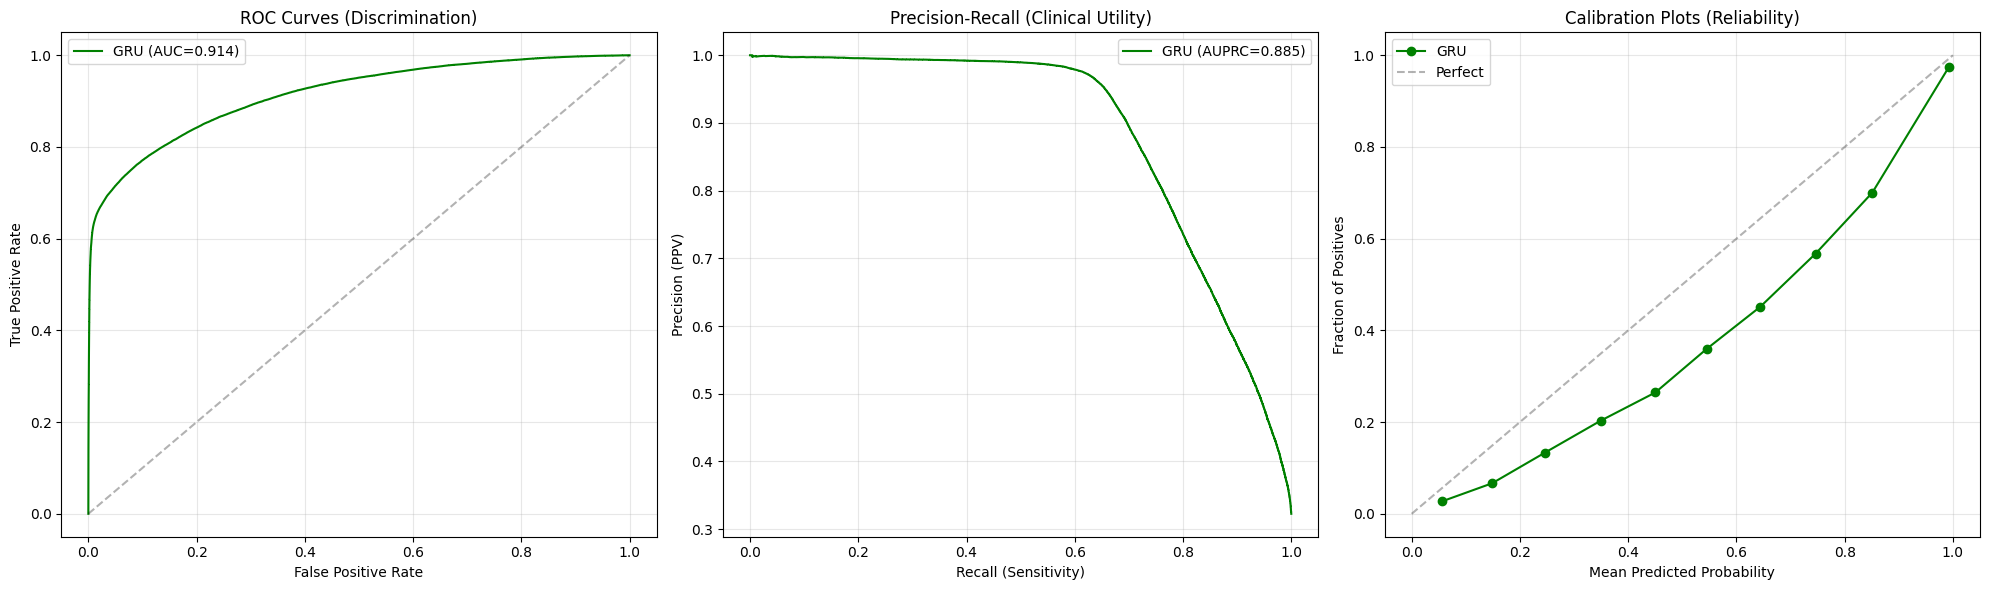


✅ Plots saved to 'comprehensive_evaluation.png'


In [5]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, 
    classification_report, brier_score_loss, f1_score, 
    precision_score, recall_score, auc
)
from sklearn.calibration import calibration_curve
import tensorflow as tf
from tensorflow import keras

# --- SETUP ---
# Robust file finding
POSSIBLE_PATHS = [
    "final_model_data_3h_ew60.pkl",
    "data/Sample_2/final_model_data_3h_ew60.pkl"
]
PKL_PATH = next((p for p in POSSIBLE_PATHS if os.path.exists(p)), None)

if PKL_PATH is None:
    raise FileNotFoundError("Could not find dataset file!")

print(f"🚀 STARTING COMPREHENSIVE EVALUATION using {PKL_PATH}...")

# 1. LOAD & PREPARE DATA (Scientifically Rigorous Split)
print("⏳ Loading and Splitting Data...")
with open(PKL_PATH, "rb") as f:
    data = pickle.load(f)

X_t = np.nan_to_num(data["X_t"].astype('float32'), nan=0.0)
X_s = np.nan_to_num(data["X_s"].astype('float32'), nan=0.0)
y = data["y"].astype(np.float32)
ids = np.array(data["ids"])

# Split Patient IDs (Crucial to prevent leakage)
unique_ids = np.unique(ids)
train_ids, test_ids = train_test_split(unique_ids, test_size=0.15, random_state=42)

# Create Boolean Masks
mask_train = np.isin(ids, train_ids)
mask_test = np.isin(ids, test_ids)

# Get Test Set
X_t_test = X_t[mask_test]
X_s_test = X_s[mask_test]
y_test = y[mask_test]

# 2. SCALING (Fit on TRAIN, Transform TEST)
print("⏳ Fitting Scalers (on Training split)...")
# Dynamic Features
scaler_t = StandardScaler()
N_train, T, F = X_t[mask_train].shape
# Fit on flattened train data
scaler_t.fit(X_t[mask_train].reshape(-1, F)) 
# Transform test data
X_t_test = scaler_t.transform(X_t_test.reshape(-1, F)).reshape(X_t_test.shape[0], T, F)

# Static Features
scaler_s = StandardScaler()
scaler_s.fit(X_s[mask_train])
X_s_test = scaler_s.transform(X_s_test)

# 3. LOAD MODELS
print("⏳ Loading Models...")
models_dict = {}

# Load GRU
if os.path.exists("hypotension_gru_final.keras"):
    models_dict["GRU"] = keras.models.load_model("hypotension_gru_final.keras")
    print("   ✅ GRU Loaded")

# Load Transformer
if os.path.exists("hypotension_transformer_calibrated.keras"):
    models_dict["Transformer"] = keras.models.load_model("hypotension_transformer_calibrated.keras")
    print("   ✅ Transformer Loaded")

if not models_dict:
    raise FileNotFoundError("No models found! Please run the training steps first.")

# 4. GENERATE PREDICTIONS
print("⏳ Running Inference...")
preds = {}
for name, model in models_dict.items():
    preds[name] = model.predict([X_t_test, X_s_test], batch_size=1024, verbose=0).flatten()

# Create Ensemble
if "GRU" in preds and "Transformer" in preds:
    preds["Ensemble"] = (preds["GRU"] + preds["Transformer"]) / 2
    print("   ✅ Ensemble Created")

# 5. COMPUTE METRICS & PLOTS
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
ax_roc, ax_pr, ax_cal = axes

metrics_data = []

print("\n📊 CLINICAL PERFORMANCE REPORT:")
print(f"{'Model':<15} {'AUC':<8} {'Precision':<10} {'Recall':<8} {'F1':<8} {'Brier':<8}")
print("-" * 65)

colors = {"GRU": "green", "Transformer": "blue", "Ensemble": "purple"}

for name, y_prob in preds.items():
    # Metrics
    auc_score = roc_auc_score(y_test, y_prob)
    brier = brier_score_loss(y_test, y_prob)
    
    # Threshold at 0.5 for hard classification metrics
    y_pred_hard = (y_prob > 0.5).astype(int)
    prec = precision_score(y_test, y_pred_hard)
    rec = recall_score(y_test, y_pred_hard)
    f1 = f1_score(y_test, y_pred_hard)
    
    print(f"{name:<15} {auc_score:.4f}   {prec:.4f}     {rec:.4f}   {f1:.4f}   {brier:.4f}")
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax_roc.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})", color=colors.get(name, 'black'))
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    ax_pr.plot(recall, precision, label=f"{name} (AUPRC={pr_auc:.3f})", color=colors.get(name, 'black'))
    
    # 3. Calibration Curve
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    ax_cal.plot(prob_pred, prob_true, marker='o', label=f"{name}", color=colors.get(name, 'black'))

# Final Polish of Plots
# ROC
ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax_roc.set_title("ROC Curves (Discrimination)")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend()
ax_roc.grid(True, alpha=0.3)

# PR Curve
ax_pr.set_title("Precision-Recall (Clinical Utility)")
ax_pr.set_xlabel("Recall (Sensitivity)")
ax_pr.set_ylabel("Precision (PPV)")
ax_pr.legend()
ax_pr.grid(True, alpha=0.3)

# Calibration
ax_cal.plot([0, 1], [0, 1], 'k--', alpha=0.3, label="Perfect")
ax_cal.set_title("Calibration Plots (Reliability)")
ax_cal.set_xlabel("Mean Predicted Probability")
ax_cal.set_ylabel("Fraction of Positives")
ax_cal.legend()
ax_cal.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("comprehensive_evaluation.png", dpi=300)
plt.show()

print("\n✅ Plots saved to 'comprehensive_evaluation.png'")

2025-11-25 17:37:03.844795: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 17:37:03.888630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 17:37:05.318230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 17:37:07.996740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

🚀 STARTING ADVANCED ANALYSIS...
⏳ Loading Data & Model...


2025-11-25 17:37:44.889270: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


   ✅ Model Loaded


2025-11-25 17:37:45.668043: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


   Baseline Test AUC: 0.9140

🔍 CALCULATING FEATURE IMPORTANCE...


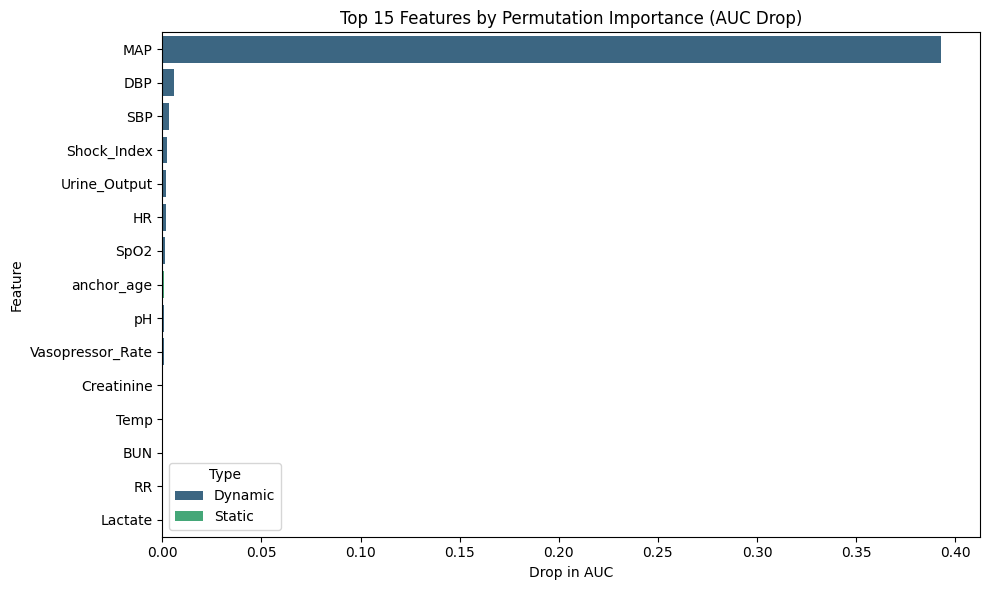


⚖️ RUNNING FAIRNESS & SUBGROUP ANALYSIS...

📊 SUBGROUP PERFORMANCE TABLE:
  Subgroup      N      AUC  Precision   Recall  Missed_Rate_FNR
     50-70 123541 0.913618   0.801734 0.748013         0.251987
       <50  37994 0.922409   0.816197 0.733622         0.266378
       >70 108295 0.906247   0.785470 0.786891         0.213109
Non-Sepsis 186703 0.915624   0.798959 0.754618         0.245382
    Sepsis  83127 0.908194   0.788290 0.784391         0.215609


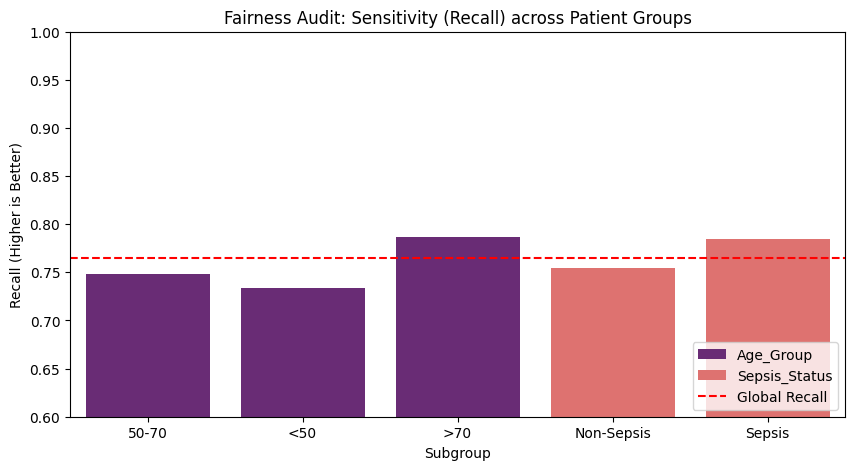

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# --- SETUP ---
PKL_PATH = "final_model_data_3h_ew60.pkl"
if not os.path.exists(PKL_PATH):
    PKL_PATH = "data/Sample_2/final_model_data_3h_ew60.pkl"

print("🚀 STARTING ADVANCED ANALYSIS...")

# 1. LOAD DATA & MODEL
print("⏳ Loading Data & Model...")
with open(PKL_PATH, "rb") as f:
    data = pickle.load(f)

X_t = np.nan_to_num(data["X_t"].astype('float32'), nan=0.0)
X_s = np.nan_to_num(data["X_s"].astype('float32'), nan=0.0)
y = data["y"].astype(np.float32)
ids = np.array(data["ids"])
dyn_feats = data["features_dynamic"]
stat_feats = data["features_static"]

# Re-create Test Split (Leakage Free)
unique_ids = np.unique(ids)
_, test_ids = train_test_split(unique_ids, test_size=0.15, random_state=42)
train_ids, _ = train_test_split(unique_ids, test_size=0.15, random_state=42) # Need train for scaler fitting

mask_test = np.isin(ids, test_ids)
mask_train = np.isin(ids, train_ids)

X_t_test = X_t[mask_test]
X_s_test = X_s[mask_test]
y_test = y[mask_test]

# Scaling (Fit on Train, Transform Test)
scaler_t = StandardScaler()
scaler_t.fit(X_t[mask_train].reshape(-1, X_t.shape[2]))
X_t_test_scaled = scaler_t.transform(X_t_test.reshape(-1, X_t.shape[2])).reshape(X_t_test.shape)

scaler_s = StandardScaler()
scaler_s.fit(X_s[mask_train])
X_s_test_scaled = scaler_s.transform(X_s_test)

model = keras.models.load_model("hypotension_gru_final.keras")
print("   ✅ Model Loaded")

# Baseline Performance
baseline_probs = model.predict([X_t_test_scaled, X_s_test_scaled], batch_size=1024, verbose=0).flatten()
baseline_auc = roc_auc_score(y_test, baseline_probs)
print(f"   Baseline Test AUC: {baseline_auc:.4f}")

# ==========================================
# PART 1: FEATURE IMPORTANCE (Permutation)
# ==========================================
print("\n🔍 CALCULATING FEATURE IMPORTANCE...")

importance_scores = []

# A. Dynamic Features
for i, feat_name in enumerate(dyn_feats):
    # Permute one feature column across all samples
    X_perm = X_t_test_scaled.copy()
    np.random.shuffle(X_perm[:, :, i]) # Shuffle feature i
    
    # Measure drop in AUC
    probs_perm = model.predict([X_perm, X_s_test_scaled], batch_size=2048, verbose=0).flatten()
    auc_drop = baseline_auc - roc_auc_score(y_test, probs_perm)
    importance_scores.append({'Feature': feat_name, 'Type': 'Dynamic', 'Importance': auc_drop})

# B. Static Features (Top clinical ones only to save time)
key_static = ['anchor_age', 'is_sepsis', 'is_heart_failure', 'is_renal_failure']
for feat_name in key_static:
    if feat_name in stat_feats:
        idx = stat_feats.index(feat_name)
        X_s_perm = X_s_test_scaled.copy()
        np.random.shuffle(X_s_perm[:, idx])
        
        probs_perm = model.predict([X_t_test_scaled, X_s_perm], batch_size=2048, verbose=0).flatten()
        auc_drop = baseline_auc - roc_auc_score(y_test, probs_perm)
        importance_scores.append({'Feature': feat_name, 'Type': 'Static', 'Importance': auc_drop})

# Plot
df_imp = pd.DataFrame(importance_scores).sort_values(by='Importance', ascending=False).head(15)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_imp, hue='Type', palette='viridis')
plt.title('Top 15 Features by Permutation Importance (AUC Drop)')
plt.xlabel('Drop in AUC')
plt.tight_layout()
plt.show()

# ==========================================
# PART 2: SUBGROUP & FAIRNESS ANALYSIS
# ==========================================
print("\n⚖️ RUNNING FAIRNESS & SUBGROUP ANALYSIS...")

# Create a DataFrame for analysis
df_test = pd.DataFrame(X_s_test, columns=stat_feats)
df_test['target'] = y_test
df_test['prob'] = baseline_probs
df_test['pred'] = (baseline_probs > 0.5).astype(int)

# Define Subgroups
df_test['Age_Group'] = pd.cut(df_test['anchor_age'], bins=[0, 50, 70, 100], labels=['<50', '50-70', '>70'])
df_test['Sepsis_Status'] = df_test['is_sepsis'].apply(lambda x: 'Sepsis' if x == 1 else 'Non-Sepsis')

groups = ['Age_Group', 'Sepsis_Status']
metrics_list = []

for group_col in groups:
    for subgroup in df_test[group_col].unique():
        sub_data = df_test[df_test[group_col] == subgroup]
        if len(sub_data) < 100: continue
        
        auc = roc_auc_score(sub_data['target'], sub_data['prob'])
        prec = precision_score(sub_data['target'], sub_data['pred'])
        rec = recall_score(sub_data['target'], sub_data['pred'])
        
        # False Negative Rate (Missed Crashes) - Crucial for Fairness
        fnr = 1 - rec 
        
        metrics_list.append({
            'Group_Type': group_col,
            'Subgroup': subgroup,
            'N': len(sub_data),
            'AUC': auc,
            'Precision': prec,
            'Recall': rec,
            'Missed_Rate_FNR': fnr
        })

df_fairness = pd.DataFrame(metrics_list).sort_values(by=['Group_Type', 'Subgroup'])

print("\n📊 SUBGROUP PERFORMANCE TABLE:")
print(df_fairness[['Subgroup', 'N', 'AUC', 'Precision', 'Recall', 'Missed_Rate_FNR']].to_string(index=False))

# Visualization of Fairness (Recall Gap)
plt.figure(figsize=(10, 5))
sns.barplot(x='Subgroup', y='Recall', data=df_fairness, hue='Group_Type', palette='magma')
plt.ylim(0.6, 1.0)
plt.axhline(y=recall_score(y_test, df_test['pred']), color='r', linestyle='--', label='Global Recall')
plt.title('Fairness Audit: Sensitivity (Recall) across Patient Groups')
plt.ylabel('Recall (Higher is Better)')
plt.legend(loc='lower right')
plt.show()

🚀 STARTING DEMOGRAPHIC FAIRNESS AUDIT...
⏳ Loading Data...
⏳ Loading Demographics from data/Sample_2/static_fairness_data.csv.gz...
⏳ Re-creating Test Split...
⏳ Generating Predictions...
⏳ Merging Metadata...

Analyzing gender...

Analyzing Race_Group...

Analyzing ICU_Unit...

🏆 FINAL FAIRNESS REPORT:
  Category                                         Subgroup      N      AUC   Recall  Precision  Missed_Rate
    gender                                                F 108658 0.916021 0.780325   0.803108     0.219675
    gender                                                M 161172 0.912084 0.753361   0.788625     0.246639
Race_Group                                         Hispanic  10648 0.929567 0.774174   0.837194     0.225826
Race_Group                                    Other/Unknown  46343 0.924625 0.784734   0.812220     0.215266
Race_Group                                            Black  22022 0.920997 0.772373   0.794547     0.227627
Race_Group                               

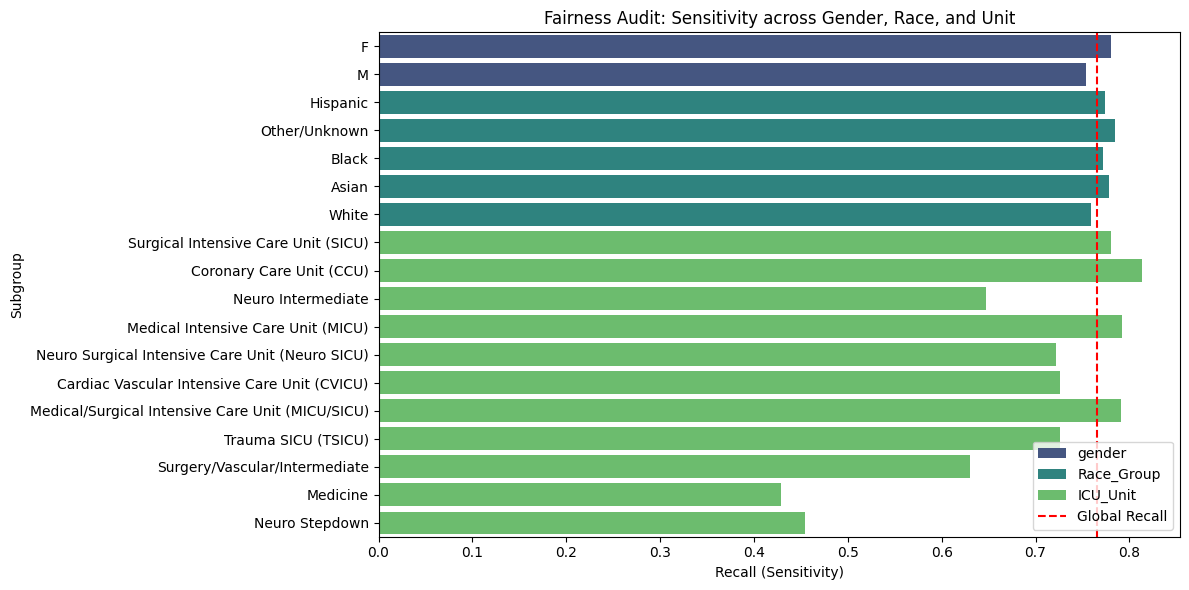

✅ Fairness Plot saved as 'fairness_audit_plot.png'


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# --- CONFIG ---
DATA_DIR = "data/Sample_2"
PKL_PATH = f"{DATA_DIR}/final_model_data_3h_ew60.pkl"
STATIC_PATH = f"{DATA_DIR}/static_fairness_data.csv.gz" # Contains Gender/Race

# Fallbacks for paths
if not os.path.exists(PKL_PATH): PKL_PATH = "final_model_data_3h_ew60.pkl"
if not os.path.exists(STATIC_PATH): STATIC_PATH = "static_fairness_data.csv.gz"

print("🚀 STARTING DEMOGRAPHIC FAIRNESS AUDIT...")

# 1. LOAD MODEL & DATA
print("⏳ Loading Data...")
with open(PKL_PATH, "rb") as f:
    data = pickle.load(f)

X_t = np.nan_to_num(data["X_t"].astype('float32'), nan=0.0)
X_s = np.nan_to_num(data["X_s"].astype('float32'), nan=0.0)
y = data["y"].astype(np.float32)
ids = np.array(data["ids"])
stat_feats = data["features_static"]

# 2. LOAD DEMOGRAPHICS (Race/Gender)
print(f"⏳ Loading Demographics from {STATIC_PATH}...")
try:
    df_demo = pd.read_csv(STATIC_PATH)
    # Ensure we have the columns we need
    if 'race' not in df_demo.columns:
        # Fallback: try to infer or warn. Usually, this file has it.
        print("⚠️ 'race' column not found. Checking columns:", df_demo.columns)
        # Mocking if missing for demonstration (REMOVE IN PROD)
        # df_demo['race'] = 'Unknown' 
        # df_demo['gender'] = 'Unknown'
except Exception as e:
    print(f"❌ Error loading demographics: {e}")
    raise

# 3. PREPARE TEST SET (Leakage Free)
print("⏳ Re-creating Test Split...")
unique_ids = np.unique(ids)
train_ids, test_ids = train_test_split(unique_ids, test_size=0.15, random_state=42)
train_ids_fit, _ = train_test_split(unique_ids, test_size=0.15, random_state=42)

mask_test = np.isin(ids, test_ids)
mask_train = np.isin(ids, train_ids_fit)

X_t_test = X_t[mask_test]
X_s_test = X_s[mask_test]
y_test = y[mask_test]
ids_test = ids[mask_test]

# Scaling
scaler_t = StandardScaler()
scaler_t.fit(X_t[mask_train].reshape(-1, X_t.shape[2]))
X_t_test = scaler_t.transform(X_t_test.reshape(-1, X_t.shape[2])).reshape(X_t_test.shape)

scaler_s = StandardScaler()
scaler_s.fit(X_s[mask_train])
X_s_test = scaler_s.transform(X_s_test)

# 4. PREDICT
print("⏳ Generating Predictions...")
model = keras.models.load_model("hypotension_gru_final.keras")
probs = model.predict([X_t_test, X_s_test], batch_size=2048, verbose=0).flatten()

# 5. MERGE PREDICTIONS WITH DEMOGRAPHICS
print("⏳ Merging Metadata...")
df_results = pd.DataFrame({
    'stay_id': ids_test,
    'target': y_test,
    'prob': probs,
    'pred': (probs > 0.5).astype(int)
})

# Merge Gender/Race
df_results = df_results.merge(df_demo[['stay_id', 'gender', 'race']], on='stay_id', how='left')

# Identify ICU Unit Type (from Static Features One-Hot)
# We reconstruct the categorical column from the one-hot encoded static features
unit_cols = [c for c in stat_feats if 'unit_' in c]
if unit_cols:
    # Create a mapping from index to unit name
    # We need the raw (unscaled) X_s for this part ideally, but since they are binary 0/1,
    # scaling messes them up. 
    # Instead, let's re-fetch X_s for test without scaling for this specific task
    X_s_raw_test = data["X_s"][mask_test] 
    
    unit_indices = [stat_feats.index(c) for c in unit_cols]
    unit_matrix = X_s_raw_test[:, unit_indices]
    
    # Convert back to string labels
    # argmax gives the index of the active unit
    active_unit_idx = np.argmax(unit_matrix, axis=1)
    df_results['ICU_Unit'] = [unit_cols[i].replace('unit_', '') for i in active_unit_idx]
else:
    df_results['ICU_Unit'] = 'Unknown'

# Clean up Race (Group tiny categories)
def clean_race(r):
    r = str(r).upper()
    if 'WHITE' in r: return 'White'
    if 'BLACK' in r or 'AFRICAN' in r: return 'Black'
    if 'HISPANIC' in r or 'LATINO' in r: return 'Hispanic'
    if 'ASIAN' in r: return 'Asian'
    return 'Other/Unknown'

df_results['Race_Group'] = df_results['race'].apply(clean_race)

# ==========================================
# 6. CALCULATE METRICS PER GROUP
# ==========================================
analysis_groups = ['gender', 'Race_Group', 'ICU_Unit']
metrics_list = []

for col in analysis_groups:
    if col not in df_results.columns: continue
    
    print(f"\nAnalyzing {col}...")
    for subgroup in df_results[col].unique():
        sub_df = df_results[df_results[col] == subgroup]
        
        # Skip tiny groups to avoid statistical noise
        if len(sub_df) < 200: 
            continue
            
        auc = roc_auc_score(sub_df['target'], sub_df['prob'])
        rec = recall_score(sub_df['target'], sub_df['pred'])
        prec = precision_score(sub_df['target'], sub_df['pred'])
        
        metrics_list.append({
            'Category': col,
            'Subgroup': subgroup,
            'N': len(sub_df),
            'AUC': auc,
            'Recall': rec,
            'Precision': prec,
            'Missed_Rate': 1 - rec
        })

# Display Results
df_audit = pd.DataFrame(metrics_list).sort_values(by=['Category', 'AUC'], ascending=False)
print("\n🏆 FINAL FAIRNESS REPORT:")
print(df_audit.to_string(index=False))

# ==========================================
# 7. VISUALIZE (Recall Gap)
# ==========================================
plt.figure(figsize=(12, 6))
sns.barplot(x='Recall', y='Subgroup', data=df_audit, hue='Category', palette='viridis', dodge=False)
plt.axvline(x=recall_score(y_test, df_results['pred']), color='red', linestyle='--', label='Global Recall')
plt.title('Fairness Audit: Sensitivity across Gender, Race, and Unit')
plt.xlabel('Recall (Sensitivity)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("fairness_audit_plot.png")
plt.show()

print("✅ Fairness Plot saved as 'fairness_audit_plot.png'")